In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

# import bt_mle_utils as mle
# from simulation_utils import *

In [21]:
def get_beta_with_gap(N, delta = 0.1):
    beta = np.arange(N) * delta
    beta = beta - np.mean(beta)
    return beta

def get_er_edge(n, m):
    """
    generate m edges uniformly randomly from a graph with n nodes
    """
    all_edge = np.where(np.triu(np.ones((n,n)), 1))
    ix = np.random.choice(n * (n - 1) // 2, m, replace = True)
    edge = [(all_edge[0][i], all_edge[1][i]) for i in ix]
    return edge

def get_X_from_edge(edge, n):
    m = len(edge)
    X = np.zeros((m, n))
    for i, e in enumerate(edge):
        X[i,e[0]] = 1
        X[i,e[1]] = -1
    return X

def get_X(n, m):
    edge = get_er_edge(n, m)
    return get_X_from_edge(edge, n)


def logistic(X, beta):
    beta = beta.reshape((-1,1))
#     t = np.clip(X @ beta, a_max = 1000, a_min = -1000)
    t = X @ beta
    exp = np.exp(t)
    return exp / (1 + exp)

def loglike_logistic(X, beta, y):
    y = y.reshape((-1,1)) 
    t = X @ beta
    res = y.T @ t - np.sum(np.log(1 + np.exp(t)))
    return res.item()
#     prob = logistic(X, beta)
#     return np.sum(y * np.log(prob + 1e-8) + (1 - y) * np.log(1 - prob + 1e-8))
#     return np.sum(y * np.log(prob) + (1 - y) * np.log(1 - prob))

def grad_logistic(X, beta, y):
    prob = logistic(X, beta)
    return X.T @ (y.reshape((-1,1)) - prob)

def hessian_logistic(X, beta, y):
    prob = logistic(X, beta).reshape((len(y),))
#     return -(prob * (1 - prob) * X.T) @ X - 1e-8 * np.eye(X.shape[1])
    return -(prob * (1 - prob) * X.T) @ X

def bt_loss(beta, X_train, y_train, lam):
    return -loglike_logistic(X_train, beta, y_train) + lam / 2 * np.sum(beta**2)

def bt_newton_solver(X_train, y_train, lam = 0.1, max_step = 50, tol = 1e-12, verbose = False):
    n, p = X_train.shape
    beta_hat = np.zeros((p,1))
    step_size = 1
    l_path = []
    i = 0
    
    err = 10
    a, b = 0.01, 0.3
    max_back = 100

    obj_old = np.inf
    while i < max_step and err > tol:
        g = -grad_logistic(X_train, beta_hat, y_train) + lam * beta_hat
        H = -hessian_logistic(X_train, beta_hat, y_train) + lam * np.eye(p)
        beta_new = beta_hat + 0
        s = step_size

        v = -np.linalg.solve(H, g)
        for j in range(max_back):
            beta_new = beta_new + s * v
            obj_new = -loglike_logistic(X_train, beta_new, y_train) + lam / 2 * np.sum(beta_new**2)
            if obj_new <= obj_old + b * s * g.T @ v:
                break
            s *= a
#         err = np.sum((beta_new - beta_hat)**2)**0.5
        beta_hat = beta_new
        err = np.sum((-grad_logistic(X_train, beta_hat, y_train) + lam * beta_hat)**2)**0.5
        obj_old = obj_new
        l_path.append(obj_new)
        i += 1
        if verbose:
            print("step: ",i," is done")
    if verbose:
        print('i: ', i)
        print("err: ", err)
        print("beta_hat: ", beta_hat)
    
    return beta_hat, l_path

def logistic_beta_error(beta, beta_hat):
    beta = beta.squeeze()
    beta_hat = beta_hat.squeeze()    
    return np.sum((beta - beta_hat)**2)**0.5, np.sum(np.abs(beta - beta_hat)**2)**0.5 / np.sum(np.abs(beta)**2)**0.5

def logistic_y_error(beta, beta_hat, n = 10000):
    p = len(beta)
    X_test = np.random.uniform(0,1,(n,p))
    y_test = np.random.binomial(1, logistic(X_test, beta))
    y_hat = (logistic(X_test, beta_hat) > 0.5).astype(int)
    return np.sum(np.abs(y_test - y_hat)) / n

def logistic_prob_error(beta, beta_hat, n = 10000):
    p = len(beta)
    X_test = np.random.uniform(0,1,(n,p))
    prob_test = logistic(X_test, beta)
    prob_hat = logistic(X_test, beta_hat)
    return np.sum(np.abs(prob_test - prob_hat)) / n


In [75]:
def dp_grid_covariate(X, Y, grid, lamb, gamma, loss_func, estimate_func, smooth = 100, buffer = 200):
    """
    X: n x p array
    """
    n, p = X.shape
    point_map = np.ones(n) * -1
    B = np.ones(n) * np.infty
    B[0] = gamma
    
    r_cand = np.concatenate([np.array([0]), grid, np.array([n - 1])])
    grid_ix = {x:i for i, x in enumerate(r_cand)}
    l_cand = np.concatenate([np.array([0]), grid])
    m = len(grid)
    dp = [[np.infty] * (m + 2) for r in range(m + 1)]
    
    for r in r_cand:
        for l in l_cand:
            if l >= r:
                break
            Y_sub, X_sub = Y[l:r], X[l:r]
            
            estimate, _ = estimate_func(X_sub, Y_sub, lam)
#             print(estimate.shape)
#             print(X_sub.shape)
#             print(Y_sub.shape)
            b = B[l] + gamma + loss_func(estimate, X_sub, Y_sub, lam)
            
            dp[grid_ix[l]][grid_ix[r]] = b
            
            if b < B[r]:
                B[r] = b
                point_map[r] = l
    
    k = n - 1
    cp_loc, cp_val = set([]), []
    while k > 0:
        h = int(point_map[k])
        if h > 0:
            cp_loc.add(h)
        k = h
    cp_loc = sorted(cp_loc)
#     for loc in cp_loc:
    return cp_loc, B, dp

In [44]:
T = 3
n = 50
m = np.array([10000, 10000, 10000])
cp_truth = np.cumsum(m)[:T-1]

beta = np.zeros((T, n))

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta_t = get_beta_with_gap(n, delta)
beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
beta[0] = beta_t[:]
beta[1] = beta_t[np.random.permutation(n)]
beta[2] = beta[1][np.random.permutation(n)]

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
print(diff)

# X_train = np.random.normal(0,1,(n,p))
X_train = np.stack([get_X(n, m[t]) for t in range(T)])
y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

X_train_joint = X_train.reshape((-1, n))
y_train_joint = y_train.reshape((-1, 1))
Y = np.zeros_like(X_train_joint)
nt = len(y_train_joint)
for i in range(nt):
    Y[i] = X_train_joint[i] * (2 * y_train_joint[i] - 1)

[6.06834094 6.4221785 ]


In [45]:
np.arange(0, nt, step = 5000)

array([    0,  5000, 10000, 15000, 20000, 25000])

In [124]:
grid = np.arange(0, nt, step = 2000)[1:]
gamma = 40 * np.log(nt * n)
lamb = 0.1

cp_loc, B, dp = dp_grid_covariate(X_train_joint, y_train_joint, grid, lamb, gamma, bt_loss, bt_newton_solver)

In [125]:
grid

array([ 2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000, 18000,
       20000, 22000, 24000, 26000, 28000])

In [126]:
cp_loc

[10000, 20000]

In [127]:
len(grid)

14

In [81]:
len(dp), len(dp[0])

(6, 7)

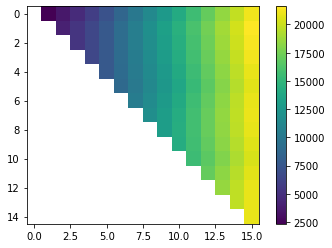

In [128]:
plt.imshow(dp)
plt.colorbar()
plt.show()

In [129]:
m = len(grid)
loss_value = np.ones((m,m)) * np.infty
for i in range(m):
    for j in range(i + 1, m):
#         v = dp[j + 1][m + 1] + dp[i + 1][j + 1] + dp[0][i + 1]
        intervals = [[0, grid[i]], [grid[i], grid[j]],[grid[j], nt]]
        v = 2 * gamma
        for interval in intervals:
            l, r = interval[0], interval[1]
            Y_sub, X_sub = y_train_joint[l:r], X_train_joint[l:r]
            estimate, _ = bt_newton_solver(X_sub, Y_sub, lam)
            v += bt_loss(estimate, X_sub, Y_sub, lam)
        loss_value[i][j] = v

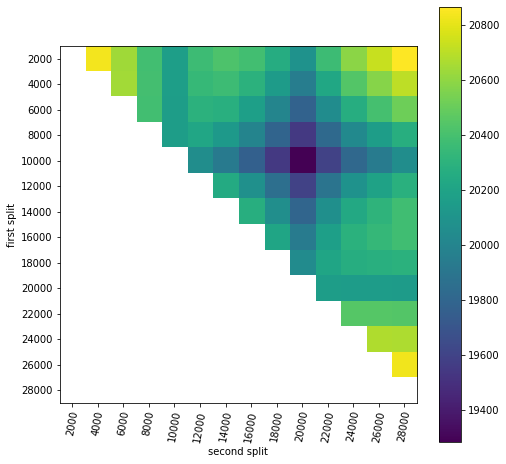

<Figure size 432x288 with 0 Axes>

In [134]:
plt.figure(figsize=(8,8))
plt.imshow(loss_value)

x_positions = np.arange(0,len(grid)) # pixel count at label position
x_labels = grid # labels you want to see
plt.xticks(x_positions, x_labels, rotation = 80)
plt.xlabel('second split')
y_positions = np.arange(0,len(grid)) # pixel count at label position
y_labels = grid # labels you want to see
plt.yticks(y_positions, y_labels)
plt.ylim(len(grid) - 0.5, -0.5)
plt.ylabel('first split')

plt.colorbar()
plt.show()
plt.savefig('dp_bt_2cp.pdf')

In [68]:
B[B < np.infty]

array([  568.83902664,  4142.47244533,  7164.27196086, 10719.69366892,
       13761.2648598 , 17377.30990566, 20422.41316157])

In [70]:
grid

array([ 5000, 10000, 15000, 20000, 25000])

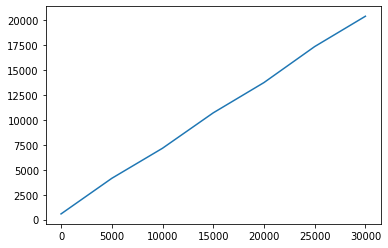

In [69]:
plt.plot(np.arange(nt)[B < np.infty], B[B < np.infty], '-')

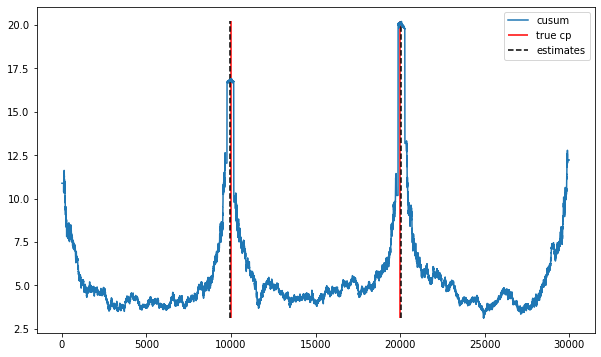

In [156]:
plt.figure(figsize = (10, 6))
plt.plot(cusum_val, '-')
plt.vlines(cp_truth, color = 'red', label = "true cp", ymin = min(cusum_val), ymax = max(cusum_val))
plt.vlines(cp_loc, color = 'black', linestyles = "dashed", label = "estimates", ymin = min(cusum_val), ymax = max(cusum_val))
plt.legend(["cusum", "true cp", "estimates"])

In [42]:
beta_hat.shape

(50, 1)

In [41]:
n = 50

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta = get_beta_with_gap(n, delta)
beta *= kappa / (np.max(beta) - np.min(beta))

m = 10000

X_train = get_X(n, m)
y_train = np.random.binomial(1, logistic(X_train, beta))

beta_hat, l_path = bt_newton_solver(X_train, y_train)

print(logistic_beta_error(beta, beta_hat))
print(logistic_y_error(beta, beta_hat))
print(logistic_prob_error(beta, beta_hat))

(0.7542433465221183, 0.1648373455879665)
0.3003
0.03232437871088981


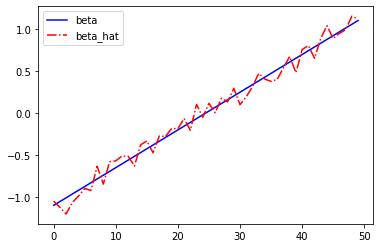

In [66]:
plt.plot(beta, 'b-')
plt.plot(beta_hat, 'r-.')
plt.legend(['beta','beta_hat'])

In [53]:
l_path

[-5870.348435704885,
 -5853.039842428691,
 -5852.991035908558,
 -5852.991035414691,
 -5852.991035414691,
 -5852.9910354146905,
 -5852.991035414692]

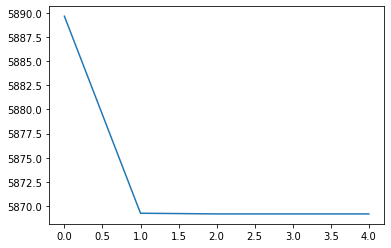

In [64]:
plt.plot(l_path)

(array([ 378.,  575.,  891.,  970.,  886., 1092., 1117., 1046., 1447.,
        1598.]),
 array([0.1       , 0.13887915, 0.17775831, 0.21663746, 0.25551662,
        0.29439577, 0.33327493, 0.37215408, 0.41103324, 0.44991239,
        0.48879155]),
 <a list of 10 Patch objects>)

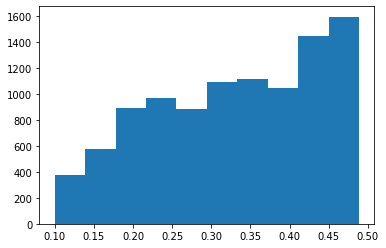

In [67]:
plt.hist(logistic(X_train, beta))

## Check magnitude of gamma

In [ ]:
def bt_loss(beta, X_train, y_train, lam):
    return -loglike_logistic(X_train, beta, y_train) + lam / 2 * np.sum(beta**2)

def bt_newton_solver(X_train, y_train, lam = 0.1, max_step = 50, tol = 1e-12, verbose = False):
    n, p = X_train.shape
    beta_hat = np.zeros((p,1))
    step_size = 1
    l_path = []
    i = 0
    
    err = 10
    a, b = 0.01, 0.3
    max_back = 100

    obj_old = np.inf
    while i < max_step and err > tol:
        g = -grad_logistic(X_train, beta_hat, y_train) + lam * beta_hat
        H = -hessian_logistic(X_train, beta_hat, y_train) + lam * np.eye(p)
        beta_new = beta_hat + 0
        s = step_size

        v = -np.linalg.solve(H, g)
        for j in range(max_back):
            beta_new = beta_new + s * v
            obj_new = -loglike_logistic(X_train, beta_new, y_train) + lam / 2 * np.sum(beta_new**2)
            if obj_new <= obj_old + b * s * g.T @ v:
                break
            s *= a
#         err = np.sum((beta_new - beta_hat)**2)**0.5
        beta_hat = beta_new
        err = np.sum((-grad_logistic(X_train, beta_hat, y_train) + lam * beta_hat)**2)**0.5
        obj_old = obj_new
        l_path.append(obj_new)
        i += 1
        if verbose:
            print("step: ",i," is done")
    if verbose:
        print('i: ', i)
        print("err: ", err)
        print("beta_hat: ", beta_hat)
    
    return beta_hat, l_path

In [17]:
T = 2
n = 50
m = 10000

beta = np.zeros((T, n))

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta_t = get_beta_with_gap(n, delta)
beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
beta[0] = beta_t[:]
beta[1] = beta_t[np.random.permutation(n)]

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
print(diff)

# X_train = np.random.normal(0,1,(n,p))
X_train = np.stack([get_X(n, m) for _ in range(T)])
y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

X_train_joint = X_train.reshape((-1, n))
y_train_joint = y_train.reshape((-1, 1))

[6.6307559]


In [26]:
nt = len(y_train_joint)
cp_truth = m
lam = 0.1

def loss_loc(loc):
    X_sub, y_sub = X_train_joint[:loc], y_train_joint[:loc]
    beta_cp1, _ = bt_newton_solver(X_sub, y_sub, lam)
    loss1 = bt_loss(beta_cp1, X_sub, y_sub, lam)

    X_sub, y_sub = X_train_joint[loc:], y_train_joint[loc:]
    beta_cp2, _ = bt_newton_solver(X_sub, y_sub, lam)
    loss2 = bt_loss(beta_cp2, X_sub, y_sub, lam)
    
    return loss1 + loss2

# loss_all[cp_truth] = loss_loc(cp_truth)
step = 500
loc_list = np.arange(step, nt, step)
loss_all = np.zeros(len(loc_list))

for i, loc in enumerate(loc_list):
    loss_all[i] = loss_loc(loc)

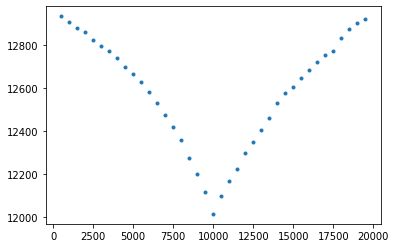

In [27]:
plt.plot(loc_list, loss_all, '.')

Two change points

In [85]:
T = 3
n = 50
m = 10000

beta = np.zeros((T, n))

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta_t = get_beta_with_gap(n, delta)
beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
beta[0] = beta_t[:]
beta[1] = beta_t[np.random.permutation(n)]
beta[2] = beta[1][np.random.permutation(n)]

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
print(diff)

# X_train = np.random.normal(0,1,(n,p))
X_train = np.stack([get_X(n, m) for _ in range(T)])
y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

X_train_joint = X_train.reshape((-1, n))
y_train_joint = y_train.reshape((-1, 1))

[6.73874156 6.5274544 ]


In [86]:
nt = len(y_train_joint)
borda_left, borda_right = np.zeros((nt, n)), np.zeros((nt, n))

borda_left[0] = X_train_joint[0][:]
borda_right[-1] = X_train_joint[-1][:]

rank_left, rank_right = np.zeros((nt, n)), np.zeros((nt, n))

rank_left[0] = stats.rankdata(borda_left[0], method = 'min')
rank_right[-1] = stats.rankdata(borda_right[-1], method = 'min')


buffer = 1000

diff = np.zeros(nt - 1)

for i in range(1, nt):
    borda_left[i] = borda_left[i - 1] + X_train_joint[i] * (2 * y_train_joint[i] - 1)
    borda_right[nt - 1 - i] = borda_right[nt - 1 - (i - 1)] + X_train_joint[nt - 1 - i] * (2 * y_train_joint[nt - 1 - i] - 1)
    
    rank_left[i] = stats.rankdata(borda_left[i], method = 'min')
    rank_right[nt - 1 - i] = stats.rankdata(borda_right[nt - 1 - i], method = 'min')

for i in range(nt - 1):
    diff[i] = np.sum(np.abs(rank_left[i] - rank_right[i + 1])) / n

In [90]:
diff[:30]

array([24.34, 23.74, 23.12, 21.78, 20.58, 20.64, 20.82, 20.58, 20.8 ,
       20.8 , 20.38, 20.5 , 20.5 , 20.22, 19.2 , 19.06, 18.3 , 18.48,
       17.96, 17.22, 17.9 , 17.72, 17.68, 17.38, 16.86, 16.94, 16.72,
       16.12, 16.48, 16.36])

In [87]:
len(diff[buffer:nt - buffer])

28000

In [71]:
np.arange(1,5)

array([1, 2, 3, 4])

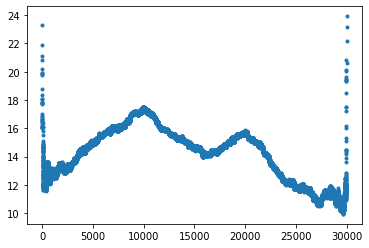

In [73]:
buffer = 0
plt.plot(np.arange(buffer, nt - 1 - buffer), diff[buffer:nt - 1 - buffer], '.')

More change points

In [117]:
T = 4
n = 50
m = 10000

beta = np.zeros((T, n))

t = 0.9
kappa = np.log(t / (1 - t))
delta = 1
beta_t = get_beta_with_gap(n, delta)
beta_t *= kappa / (np.max(beta_t) - np.min(beta_t))
beta[0] = beta_t[:]
beta[1] = beta_t[np.random.permutation(n)]
beta[2] = beta[1][np.random.permutation(n)]

diff = np.zeros(T - 1)
for t in range(1, T):
    diff[t - 1] = np.sum(np.abs(beta[t] - beta[t - 1])**2)**0.5
print(diff)

# X_train = np.random.normal(0,1,(n,p))
X_train = np.stack([get_X(n, m) for _ in range(T)])
y_train = np.stack([np.random.binomial(1, logistic(X_train[i], beta[i])) for i in range(T)])

X_train_joint = X_train.reshape((-1, n))
y_train_joint = y_train.reshape((-1, 1))

[6.52868646 6.16955266 4.57568243]


In [118]:
nt = len(y_train_joint)
borda_left, borda_right = np.zeros((nt, n)), np.zeros((nt, n))

borda_left[0] = X_train_joint[0][:]
borda_right[-1] = X_train_joint[-1][:]

rank_left, rank_right = np.zeros((nt, n)), np.zeros((nt, n))

rank_left[0] = stats.rankdata(borda_left[0], method = 'min')
rank_right[-1] = stats.rankdata(borda_right[-1], method = 'min')


buffer = 1000

diff = np.zeros(nt - 1)

for i in range(1, nt):
    borda_left[i] = borda_left[i - 1] + X_train_joint[i] * (2 * y_train_joint[i] - 1)
    borda_right[nt - 1 - i] = borda_right[nt - 1 - (i - 1)] + X_train_joint[nt - 1 - i] * (2 * y_train_joint[nt - 1 - i] - 1)
    
    rank_left[i] = stats.rankdata(borda_left[i], method = 'min')
    rank_right[nt - 1 - i] = stats.rankdata(borda_right[nt - 1 - i], method = 'min')

for i in range(nt - 1):
    diff[i] = np.sum(np.abs(rank_left[i] - rank_right[i + 1]))

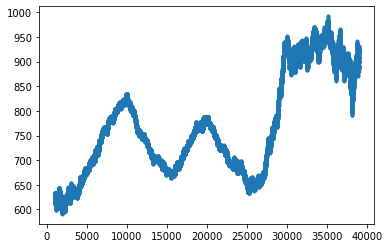

In [119]:
plt.plot(np.arange(buffer, nt - buffer), diff[buffer:nt - buffer], '.')